# Lomb Scargle Power Spectra

This tutorial shows how to make and manipulate a Lomb Scargle power spectrum of two light curves using Stingray.

In [1]:
from stingray.lightcurve import Lightcurve
from stingray.lombscargle import LombScarglePowerspectrum
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import matplotlib.font_manager as font_manager
%matplotlib inline
plt.style.use('seaborn-v0_8-talk')
font_prop = font_manager.FontProperties(size=16)

# 1\. Create a light curve

There are two ways to make `Lightcurve` objects. We'll show one way here. Check out [Lightcurve](https://docs.stingray.science/en/stable/core.html#working-with-lightcurves) for more examples.

Make one with signals in units of counts. It is a sine wave  with random normal noise, frequency of 3 and at random times and make its counts non-negative by subtracting its least value.


In [2]:
rand = np.random.default_rng(42)
n = 100
t = np.sort(rand.random(n)) * 10
y = np.sin(2 * np.pi * 3.0 * t) + 0.1 * rand.standard_normal(n)
sub = np.min(y)
y -= sub
t0 = np.linspace(0, 10, 1000)
y0 = np.sin(2 * np.pi * 3.0 * t0) + 0.1 * rand.standard_normal(t0.size)
sub = np.min(y0)
y0 -= sub
spline = make_interp_spline(t, y)

Lets convert them into `Lightcurve` objects

In [3]:
lc = Lightcurve(t, y)

/home/saurav/.local/lib/python3.12/site-packages/stingray/utils.py:486: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.Only use with LombScargleCrossspectrum, LombScarglePowerspectrum and QPO using GPResult
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


Let us plot them to see how they look

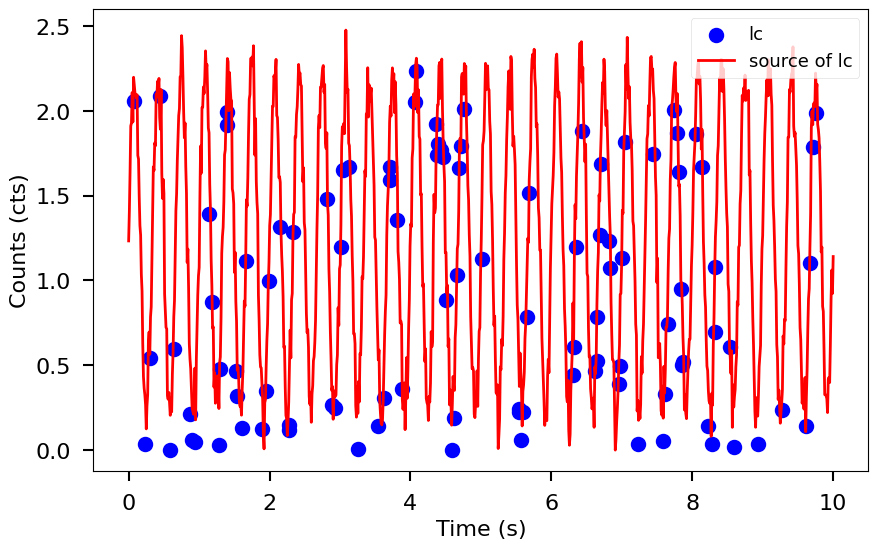

In [4]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.scatter(lc.time, lc.counts, lw=2, color='blue',label='lc')
ax.plot(t0, y0, lw=2, color='red',label='source of lc')
ax.set_xlabel("Time (s)", fontproperties=font_prop)
ax.set_ylabel("Counts (cts)", fontproperties=font_prop)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(which='major', width=1.5, length=7)
ax.tick_params(which='minor', width=1.5, length=4)
plt.legend()
plt.show()

## 2. Pass the light curve to the `LombScarglePowerspectrum` class to create a `LombScarglePowerspectrum` object.
You can also specify the optional attribute `norm` if you wish to normalize the real part of the power spectrum to squared fractional rms, Leahy, or squared absolute normalization. The default normalization is 'none'.

In [5]:
lps = LombScarglePowerspectrum(
    lc,
    min_freq=0,
    max_freq=None,
    method="fast",
    power_type="all",
    norm="none",
)

/home/saurav/.local/lib/python3.12/site-packages/stingray/lombscargle.py:76: UserWarning: min_freq must be positive and >0. Setting to df / 2.
  warnings.warn("min_freq must be positive and >0. Setting to df / 2.")


We can print the first five values in the arrays of the positive Fourier frequencies and the power. The power has only real component, and imaginary component is zero.

In [6]:
print(lps.freq[0:5])
print(lps.power[0:5])

[0.05163902 0.15491705 0.25819509 0.36147313 0.46475116]
[ 15.49526224-6.91885634e-17j 120.05686691+1.20218632e-15j
  96.589673  -2.94651403e-16j 127.2231466 -3.18961834e-15j
  30.42053746+3.38826087e-16j]


### Parameters

- `data`: This parameter allows you to provide the light curve data to be Fourier-transformed. It can be either a [`stingray.lightcurve.Lightcurve`](https://docs.stingray.science/en/stable/core.html#working-with-lightcurves) or [`stingray.events.EventList`](https://docs.stingray.science/en/stable/core.html#working-with-event-data) object. It is optional, and the default value is `None`.

- `norm`: The `norm` parameter defines the normalization of the power spectrum. It accepts string values from the set {`frac`, `abs`, `leahy`, `none`}. The default normalization is set to `none`.

- `power_type`: The `power_type` parameter allows you to specify the type of power spectral power you want to compute. The options are: `real` for the real part, `absolute` for the magnitude, and `all` to compute both real part and magnitude. The default is `all`.

- `fullspec`: This is a boolean parameter that determines whether to keep only the positive frequencies or include both positive and negative frequencies in the power spectrum. When set to `False` (default), only positive frequencies are kept; when set to `True`, both positive and negative frequencies are included.

### Other Parameters

- `dt`: When constructing light curves using [`stingray.events.EventList`](https://docs.stingray.science/en/stable/core.html#working-with-event-data) objects, the `dt` parameter represents the time resolution of the light curve. It is a float value that needs to be provided.

- `skip_checks`: This is a boolean parameter that, when set to `True`, skips initial checks for speed or other reasons. It's useful when you have confidence in the inputs and want to improve processing speed.

- `min_freq`: This parameter specifies the minimum frequency at which the Lomb-Scargle Fourier Transform should be computed.

- `max_freq`: Similarly, the `max_freq` parameter sets the maximum frequency for the Lomb-Scargle Fourier Transform.

- `df`: The `df` parameter, a float, represents the frequency resolution. It's relevant when constructing light curves using [`stingray.events.EventList`](https://docs.stingray.science/en/stable/core.html#working-with-event-data) objects.

- `method`: The `method` parameter determines the method used by the Lomb-Scargle Fourier Transformation function. The allowed values are `fast` and `slow`, with the default being `fast`. The `fast` method uses the optimized Press and Rybicki O(n*log(n)) algorithm.

- `oversampling`: This optional float parameter represents the interpolation oversampling factor. It is applicable when using the fast algorithm for the Lomb-Scargle Fourier Transform. The default value is 5.

## Attributes

- `freq`: The `freq` attribute is a numpy array that contains the mid-bin frequencies at which the Fourier transform samples the power spectrum.

- `power`: The `power` attribute is a numpy array that contains the normalized squared absolute values of Fourier amplitudes.

- `power_err`: The `power_err` attribute is a numpy array that provides the uncertainties associated with the `power`. The uncertainties are approximated using the formula `power_err = power / sqrt(m)`, where `m` is the number of power values averaged in each bin. For a single realization (`m=1`), the error is equal to the power.

- `df`: The `df` attribute is a float that indicates the frequency resolution.

- `m`: The `m` attribute is an integer representing the number of averaged powers in each bin.

- `n`: The `n` attribute is an integer indicating the number of data points in the light curve.

- `nphots`: The `nphots` attribute is a float representing the total number of photons in the light curve.

We can plot the power spectrum by using the plot function or manually taking the `freq` and `power` attributes

Text(0, 0.5, 'Power(Imaginary Component)')

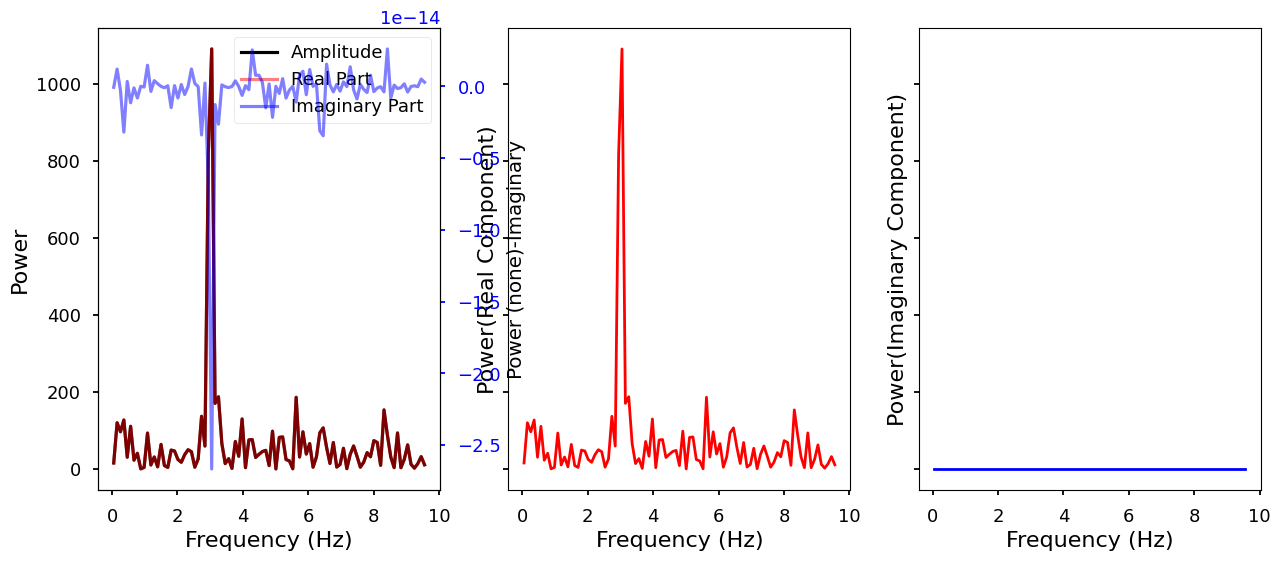

In [7]:
fig, ax = plt.subplots(1,3,figsize=(15,6),sharey=True)
lps.plot(ax=ax[0])
ax[0].set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax[0].set_ylabel("Power", fontproperties=font_prop)
ax[1].plot(lps.freq, lps.power.real, lw=2, color='red')
ax[1].set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax[1].set_ylabel("Power(Real Component)", fontproperties=font_prop)
ax[2].plot(lps.freq, lps.power.imag, lw=2, color='blue')
ax[2].set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax[2].set_ylabel("Power(Imaginary Component)", fontproperties=font_prop)